## Motivation {.unnumbered}

For this dataset, each sample is comprised of cells from multiple patients hashtagged with a unique oligo sequence. To demultiplex which patient the cells were retrieved from, a demultiplexing algorithm must be used to quantify the oligo sequences for each cell and assign each cell to a patient. The most common approaches to date is using the HTOdemux [[Stoeckius et al.; 2018]](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1603-1) or the MULTIseqDemux [[McGinnis et al.; 2019]](https://www.nature.com/articles/s41592-019-0433-8) algorithms. Besides assigning each cell back to each patient, these algorithms are able to identify homolytic/heterolytic "Doublet" and "Negative" cells based on high/multiple and low oligo counts respectively. These poor quality droplets are a common issue with droplet-based sequencing when there are multiple or no cells found in each droplet, and removal of these droplets could prevent false-positive findings.

In [24]:
## set up environment
suppressMessages({
source("/camp/home/hungm/working/Matthew/library/R/functions/Seurat/processing.R")
source("/camp/home/hungm/working/Matthew/library/R/functions/Seurat/plotting.R")
setwd("/nemo/lab/caladod/working/Matthew/project/matthew/MH_GSE155224")})

## load seurat objects
obj_list <- qread("seurat/20240825_GSE155224_raw.qs")

In [273]:
obj_list

$filtered_matrix_1
An object of class Seurat 
17028 features across 7502 samples within 3 assays 
Active assay: RNA (16828 features, 0 variable features)
 1 layer present: counts
 2 other assays present: HTO, ADT

$filtered_matrix_2
An object of class Seurat 
17301 features across 8227 samples within 3 assays 
Active assay: RNA (17101 features, 0 variable features)
 1 layer present: counts
 2 other assays present: HTO, ADT


## Calculate Gene Fractions {#sec-calculate_gene_fractions}
Before demultiplexing, we need to first calculate the fraction of mitochondrial, ribosomal, haemoglobin, T/B-cell recepter (TCR/BCR) and MHC reads to identify poor quality cells, which can be informative of accurate demultiplexing. The function below will perform the calculations of key parameters that identifies poor quality cells.
  
Please navigate to the next chapter \<Quality Control\> for a detailed explanation of the wrapper function, outputs, and interpretations.

In [274]:
## calculate gene fractions (mt, rb, hb, tcr, bcr)
for(x in 1:length(obj_list)){
    obj_list[[x]] <- calculate_fractions(obj_list[[x]])}

## Inpect HTO Counts
Before demultiplexing HTO library, we will inspect and remove any redundant/low expressing hashtags. For each sample, below we will quantify 1) how many cells expresses each tag; 2) number of counts for each tag.

> Quantification show that Hashtag-1 and Hashtag-2 are pretty much not expressed. Indeed for these sequencing runs, the author did not tag cells with Hashtag-1 and Hashtag-2. However author did not remove these Tags during cellranger-multi processing, hence some false-positive counts.

In [275]:
## Calculate how many cells expresses each tag
metalist <- list()
for(x in 1:length(obj_list)){
    metalist[[x]] <- data.frame(apply(obj_list[[x]][["HTO"]]$counts, 1, function(row) sum(row != 0)))
    colnames(metalist[[x]]) <- names(obj_list)[x]}
metalist <- bind_cols(metalist)
metalist

,filtered_matrix_1,filtered_matrix_2
,<int>,<int>
anti-human-Hashtag-1-totalC,59,86
anti-human-Hashtag-2-totalC,39,60
anti-human-Hashtag-3-totalC,7234,8044
anti-human-Hashtag-4-totalC,7494,8221
anti-human-Hashtag-5-totalC,7485,8212
anti-human-Hashtag-6-totalC,7501,8226
anti-human-Hashtag-7-totalC,7501,8224
anti-human-Hashtag-8-totalC,7500,8225


In [276]:
## Calculate number of counts for each tag
metalist <- list()
for(x in 1:length(obj_list)){
    metalist[[x]] <- data.frame(rowSums(obj_list[[x]][["HTO"]]$counts))
    colnames(metalist[[x]]) <- names(obj_list)[x]}
metalist <- bind_cols(metalist)
metalist

,filtered_matrix_1,filtered_matrix_2
,<dbl>,<dbl>
anti-human-Hashtag-1-totalC,60,86
anti-human-Hashtag-2-totalC,40,60
anti-human-Hashtag-3-totalC,93205,118714
anti-human-Hashtag-4-totalC,173037,210110
anti-human-Hashtag-5-totalC,93560,120365
anti-human-Hashtag-6-totalC,2220085,2496495
anti-human-Hashtag-7-totalC,1170763,1525116
anti-human-Hashtag-8-totalC,775182,786222


We will now remove those redundant tags from the "HTO" assay.

In [277]:
for(x in 1:length(obj_list)){
    features <- c("anti-human-Hashtag-1-totalC", "anti-human-Hashtag-2-totalC")
    obj_list[[x]] <- remove_genes(obj_list[[x]], features = features, orig.assay = "HTO", new.assay = "remove")
    obj_list[[x]][["remove"]] <- NULL}

obj_list

Warning message:
“Different cells and/or features from existing assay HTO”
Warning message:
“Different cells and/or features from existing assay HTO”


$filtered_matrix_1
An object of class Seurat 
17026 features across 7502 samples within 3 assays 
Active assay: HTO (6 features, 0 variable features)
 1 layer present: counts
 2 other assays present: RNA, ADT

$filtered_matrix_2
An object of class Seurat 
17299 features across 8227 samples within 3 assays 
Active assay: HTO (6 features, 0 variable features)
 1 layer present: counts
 2 other assays present: RNA, ADT


## HTODemux {#sec-htodemux}
First we will run the the wrapper function below to demultiplex the cells with the HTODemux algorithm in default settings.

In [278]:
## add one pseudocount to each oligo to run HTODemux without error
for(x in 1:length(obj_list)){
    obj_list[[x]] <- htodemux(obj_list[[x]], add.one = T)}

Normalizing layer: counts

Normalizing across cells

Cutoff for anti-human-Hashtag-3-totalC : 46 reads

Cutoff for anti-human-Hashtag-4-totalC : 66 reads

Cutoff for anti-human-Hashtag-5-totalC : 38 reads

Cutoff for anti-human-Hashtag-6-totalC : 122 reads

Cutoff for anti-human-Hashtag-7-totalC : 120 reads

Cutoff for anti-human-Hashtag-8-totalC : 88 reads

Normalizing layer: counts

Normalizing across cells

Cutoff for anti-human-Hashtag-3-totalC : 19 reads

Cutoff for anti-human-Hashtag-4-totalC : 38 reads

Cutoff for anti-human-Hashtag-5-totalC : 40 reads

Cutoff for anti-human-Hashtag-6-totalC : 119 reads

Cutoff for anti-human-Hashtag-7-totalC : 101 reads

Cutoff for anti-human-Hashtag-8-totalC : 105 reads



Below we will visualize the output from HTODemux to inspect the quality of the demultiplexing algorithm. We quantified the percentage of "Singlet", "Doublet" and "Negative" cells (empty droplets or cells with no tags) for each sample. 

> HTODemux is able to assign > 65% of cells as "Singlets" for both samples.

In [279]:
## Aggregate HTODemux output into a dataframe
metalist <- list()
for(x in seq_along(obj_list)){
    metalist[[x]] <- obj_list[[x]]@meta.data}
metalist <- bind_rows(metalist)

## Quantify % of Singlet cells left from each sample
metalist_qc <- metalist %>%
    group_by(samples, HTO_classification.global) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    filter(!HTO_classification.global %in% c("Doublet", "Negative")) %>%
    group_by(samples) %>%
    summarize(pct = sum(pct))
    
metalist_qc

samples,pct
<chr>,<dbl>
filtered_matrix_1,66.27566
filtered_matrix_2,69.35700


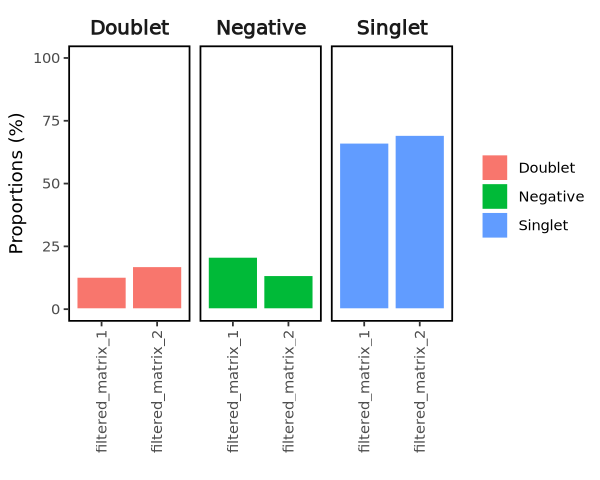

In [280]:
## Visualizde % of Singlet cells left from each sample
options(repr.plot.width=5, repr.plot.height=4)
metalist %>%
    group_by(samples, HTO_classification.global) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = samples, y = pct, fill = HTO_classification.global)) +
    geom_col(color = "white") +
    facet_wrap(~HTO_classification.global) +
    guides(fill = guide_legend(title = "")) +
    theme_bw() +
    ylim(c(0, 100)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("Proportions (%)") +
    theme_border() +
    facet_aes()

In addition, we can inspect different parameter below to see if "Doublet" and "Negative" cells are assigned appropriately. Low nFeature/nCount typically indicate if the droplet is empty, hence "Negative". Vice versa, high nFeature/nCount indicate "Doublet" cells as mRNA contents in a droplet is doubled.

> Looking at nFeature_RNA & nCounts_RNA mainly, HTODemux assignment do accurately reflect nature of the "Negative" and "Doublet" cells in our case.

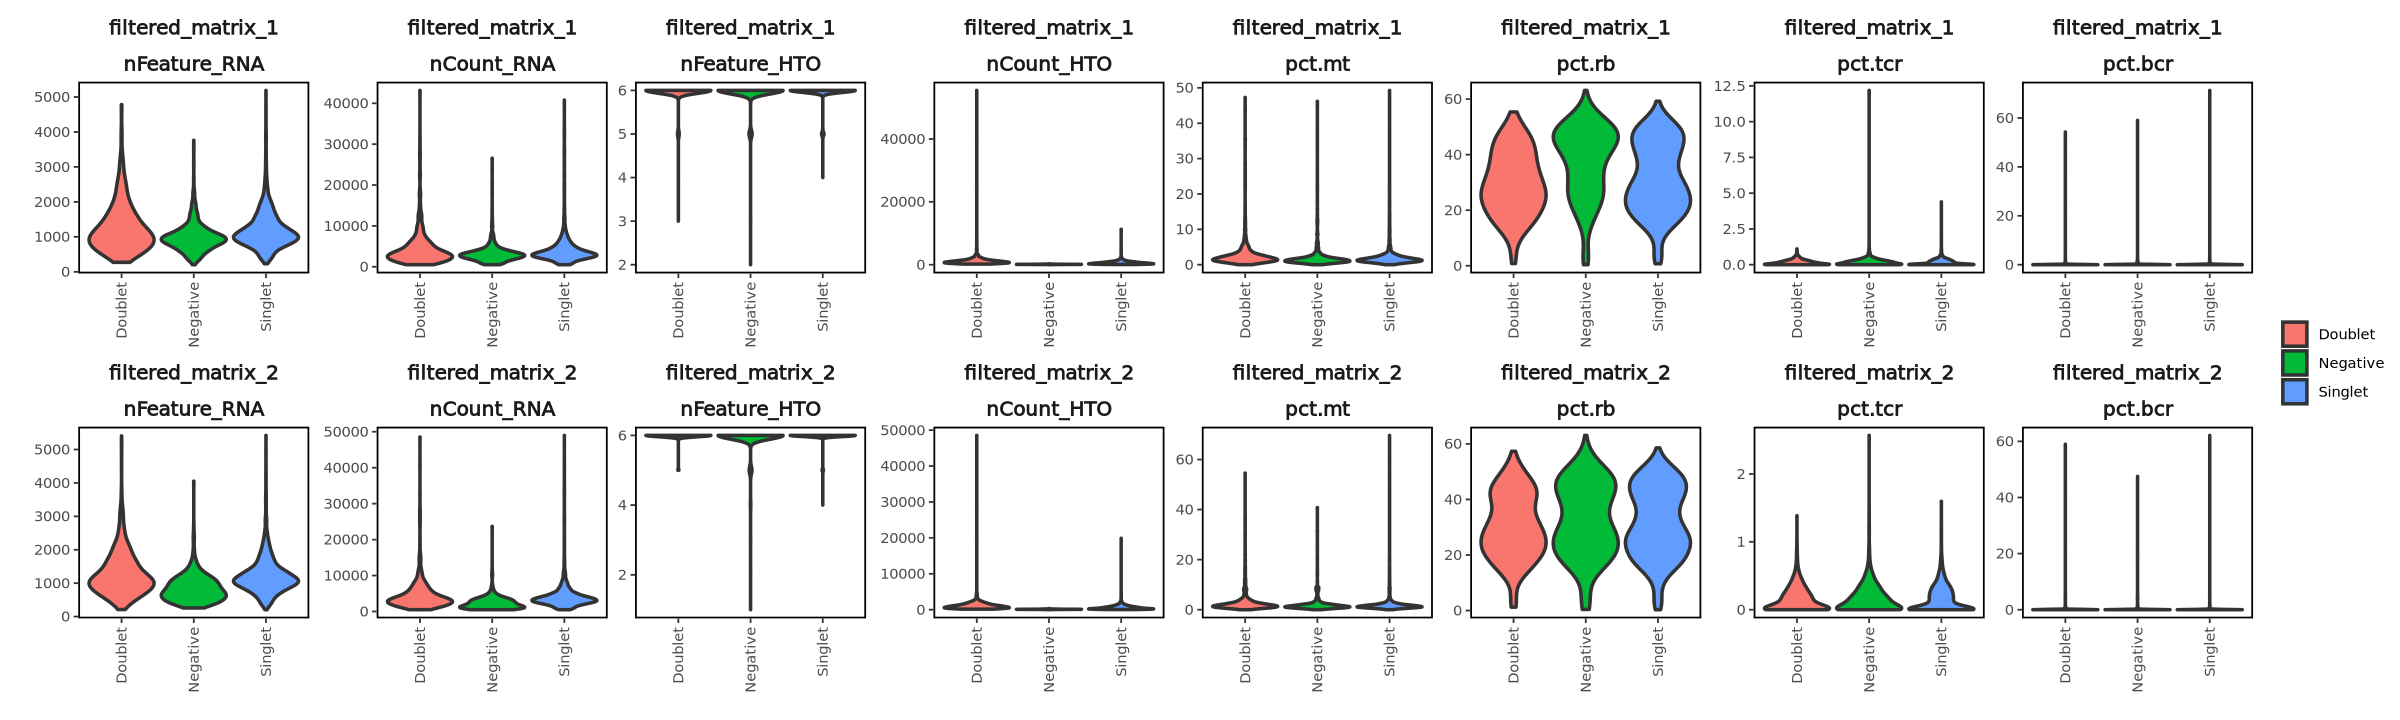

In [281]:
## inspect filtering parameters for the problematic samples
options(repr.plot.width=20, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
metalist %>%
    filter(!is.na(HTO_classification.global)) %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = HTO_classification.global, y = values, fill = HTO_classification.global)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## MULTIseqDemux {#sec-multiseqdemux}
Next we also will also implement MULTIseqDemux algorithm as a benchmark. 

In [282]:
## run MULTIseqDemux
for(x in 1:length(obj_list)){
    obj_list[[x]] <- multiseqdemux(obj_list[[x]], add.one = F)}

Normalizing layer: counts

Normalizing across cells

Normalizing layer: counts

Normalizing across cells



Below we will visualize the output from MULTIseqDemux to inspect the quality of demultiplexing. Again we quantified the percentage of "Singlet", "Doublet" and "Negative" cells for each sample. 
> Compared to HTODemux, all samples have > 70% of cells assigned as "Singlet".

In [283]:
## Aggregate MULTIseqDemux output into a dataframe
metalist <- list()
for(x in seq_along(obj_list)){
    metalist[[x]] <- obj_list[[x]]@meta.data}
metalist <- bind_rows(metalist)

## Quantify % of Singlet cells left from each sample
metalist_qc <- metalist %>%
    group_by(samples, MULTI.global) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    filter(!MULTI.global %in% c("Doublet", "Negative")) %>%
    group_by(samples) %>%
    summarize(pct = sum(pct))

metalist_qc

samples,pct
<chr>,<dbl>
filtered_matrix_1,73.14050
filtered_matrix_2,75.37377


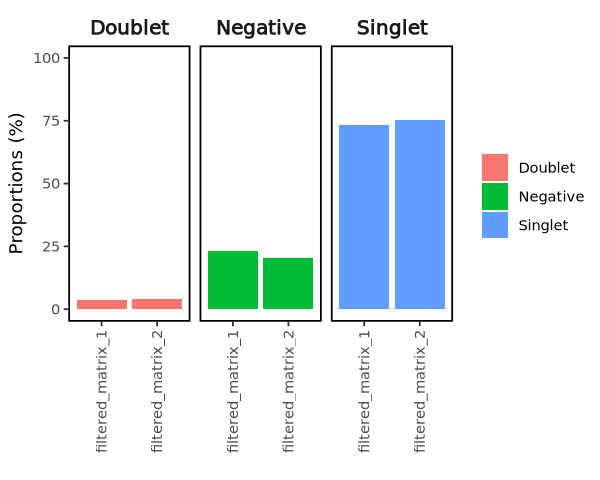

In [284]:
## Visualize % of Singlet cells left from each sample
options(repr.plot.width=5, repr.plot.height=4)
metalist %>%
    group_by(samples, MULTI.global) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = samples, y = pct, fill = MULTI.global)) +
    geom_col() +
    facet_wrap(~MULTI.global) +
    guides(fill = guide_legend(title = "")) +
    ylim(c(0, 100)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("Proportions (%)") +
    theme_border() +
    facet_aes()

Again, we can inspect different parameter below to see if "Doublet" and "Negative" cells are assigned appropriately.

> Looking at nFeature and nCounts again, nCounts and nFeatures of "Negative" cells are substantially lower than "Singlet" cells, wheres "Doublets" are much higher than "Singlet" cells. Compared to HTODemux, MULTIseqDemux may better capture true "Singlet" cells.

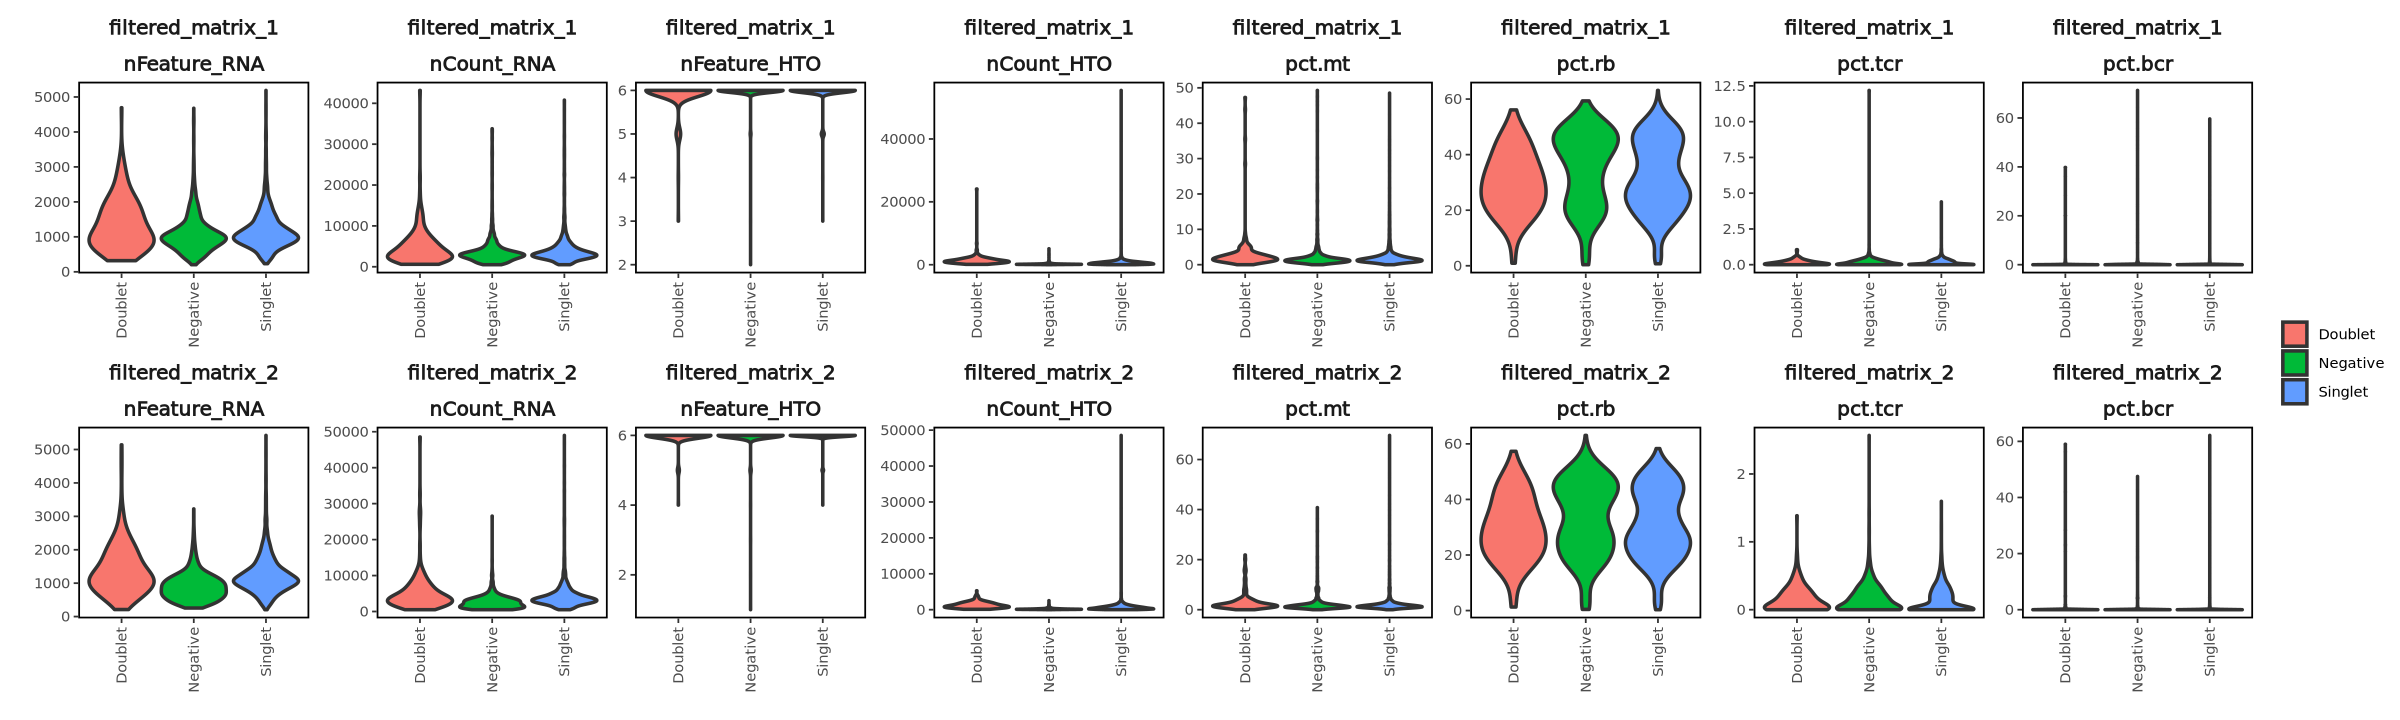

In [285]:
## inspect filtering parameters for the problematic samples
options(repr.plot.width=20, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
metalist %>%
    filter(!is.na(MULTI.global)) %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = MULTI.global, y = values, fill = MULTI.global)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## Evaluate Output {#sec-evaluateoutput}
When there are more than 5 HTO hashtags, we can perform a umap visualization to evaluate which method could best predict "Singlet" cells.

In [286]:
## make sure there are more than 5 HTO tags
nrow(obj_list[[1]][["HTO"]])
nrow(obj_list[[2]][["HTO"]])

[1] 6

[1] 6

In [287]:
## process HTO counts
obj_list <- process_hto(obj_list)

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



> UMAP below shows that MULTIseqDemux assigned a large cluster of cells as tags in both sequencing runs rather than "Doublet/Negative" to HTODemux. HTODemux has been suggested to predict more false-positive doublets compared to MULTIseqDemux (see [GitHub](https://github.com/chris-mcginnis-ucsf/MULTI-seq/issues/26) & [Paper](https://academic.oup.com/bioinformatics/article-abstract/38/10/2791/6565315))

In [288]:
# set hash ID as factors
for(x in 1:length(obj_list)){
    obj_list[[x]]$hash.ID <- factor(obj_list[[x]]$hash.ID, levels(obj_list[[x]]$MULTI_ID))}

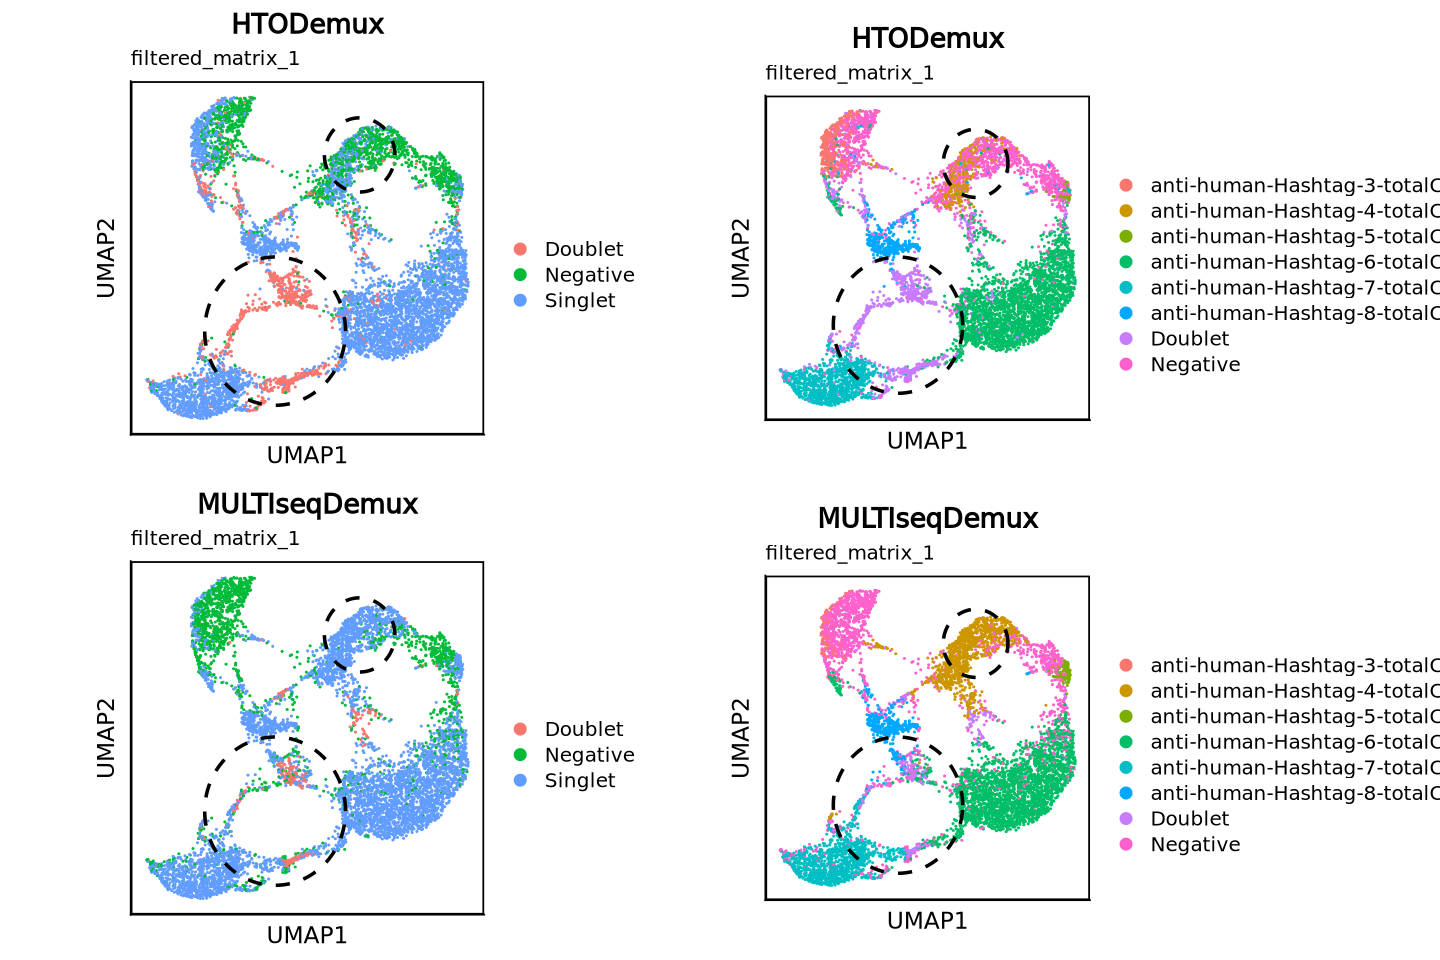

In [302]:
## Visualize HTODemux & MULTIseqDemux assignment for filtered_matrix_1
options(repr.plot.width=12, repr.plot.height= 8)
plist <- list()
plist[[length(plist) + 1]] <- scUMAP(obj_list[[1]], reduction = "umap_hto", group.by = "HTO_classification.global") + ggtitle("HTODemux", subtitle = "filtered_matrix_1" )
plist[[length(plist) + 1]] <- scUMAP(obj_list[[1]], reduction = "umap_hto", group.by = "hash.ID") + ggtitle("HTODemux", subtitle = "filtered_matrix_1")
plist[[length(plist) + 1]] <- scUMAP(obj_list[[1]], reduction = "umap_hto", group.by = "MULTI.global") + ggtitle("MULTIseqDemux", subtitle = "filtered_matrix_1")
plist[[length(plist) + 1]] <- scUMAP(obj_list[[1]], reduction = "umap_hto", group.by = "MULTI_ID") + ggtitle("MULTIseqDemux", subtitle = "filtered_matrix_1")

r = 2; xc = 2; yc = 6
for(x in seq_along(plist)){
    plist[[x]] <- plist[[x]] +
        annotate("path",
            x=xc+r*cos(seq(0,2*pi,length.out=100)),
            y=yc+r*sin(seq(0,2*pi,length.out=100)),
            size = 1,
            linetype = "dashed")}

r = 4; xc = -2.8; yc = -3.5
for(x in seq_along(plist)){
    plist[[x]] <- plist[[x]] +
        annotate("path",
            x=xc+r*cos(seq(0,2*pi,length.out=100)),
            y=yc+r*sin(seq(0,2*pi,length.out=100)),
            size = 1,
            linetype = "dashed")}

plot_grid(plotlist = plist, ncol = 2)

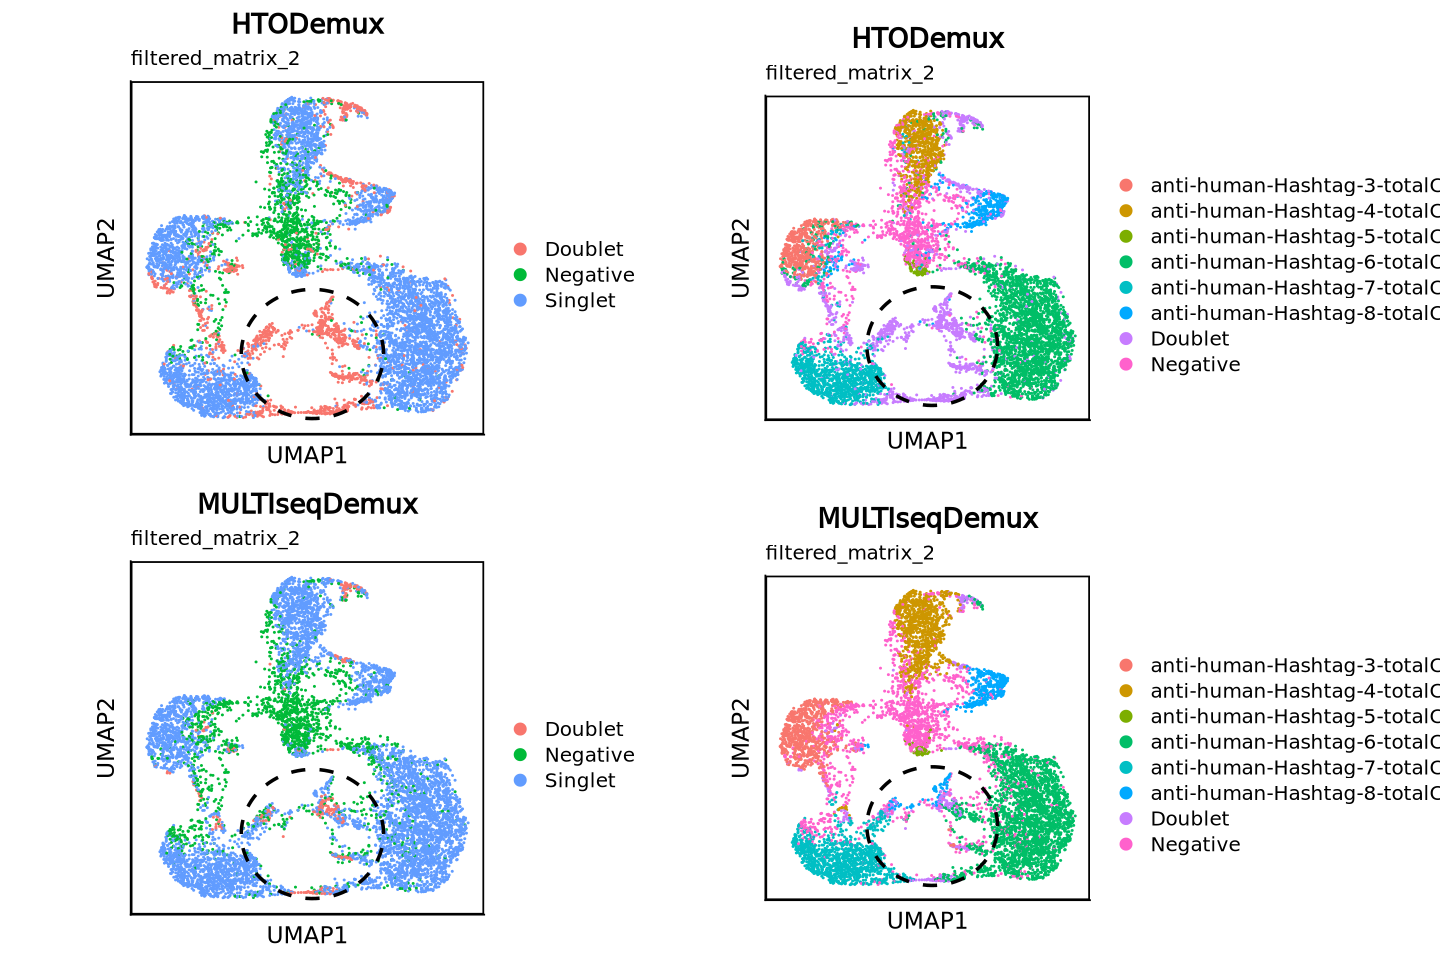

In [306]:
## Visualize HTODemux & MULTIseqDemux assignment for filtered_matrix_2
options(repr.plot.width=12, repr.plot.height= 8)
plist <- list()
plist[[length(plist) + 1]] <- scUMAP(obj_list[[2]], reduction = "umap_hto", group.by = "HTO_classification.global") + ggtitle("HTODemux", subtitle = "filtered_matrix_2" )
plist[[length(plist) + 1]] <- scUMAP(obj_list[[2]], reduction = "umap_hto", group.by = "hash.ID") + ggtitle("HTODemux", subtitle = "filtered_matrix_2")
plist[[length(plist) + 1]] <- scUMAP(obj_list[[2]], reduction = "umap_hto", group.by = "MULTI.global") + ggtitle("MULTIseqDemux", subtitle = "filtered_matrix_2")
plist[[length(plist) + 1]] <- scUMAP(obj_list[[2]], reduction = "umap_hto", group.by = "MULTI_ID") + ggtitle("MULTIseqDemux", subtitle = "filtered_matrix_2")

r = 3.5; xc = -0; yc = -3.5
for(x in seq_along(plist)){
    plist[[x]] <- plist[[x]] +
        annotate("path",
            x=xc+r*cos(seq(0,2*pi,length.out=100)),
            y=yc+r*sin(seq(0,2*pi,length.out=100)),
            size = 1,
            linetype = "dashed")}

plot_grid(plotlist = plist, ncol = 2)

## Separation of HTO Signal {#sec-htosignal}
Furthermore we will inspect the hashtag signal for the demultiplexed cells in both samples to determine whether HTODemux or MULTIseqDemux is better.

> MULTIseqDemux can separate signals from individual tags better for both sequencing runs, especially for Hashtag-8.

Picking joint bandwidth of 0.0327

Picking joint bandwidth of 0.0447

Picking joint bandwidth of 0.0344

Picking joint bandwidth of 0.0754

Picking joint bandwidth of 0.0755

Picking joint bandwidth of 0.0844

Picking joint bandwidth of 0.0336

Picking joint bandwidth of 0.0523

Picking joint bandwidth of 0.0353

Picking joint bandwidth of 0.0992

Picking joint bandwidth of 0.0899

Picking joint bandwidth of 0.0971



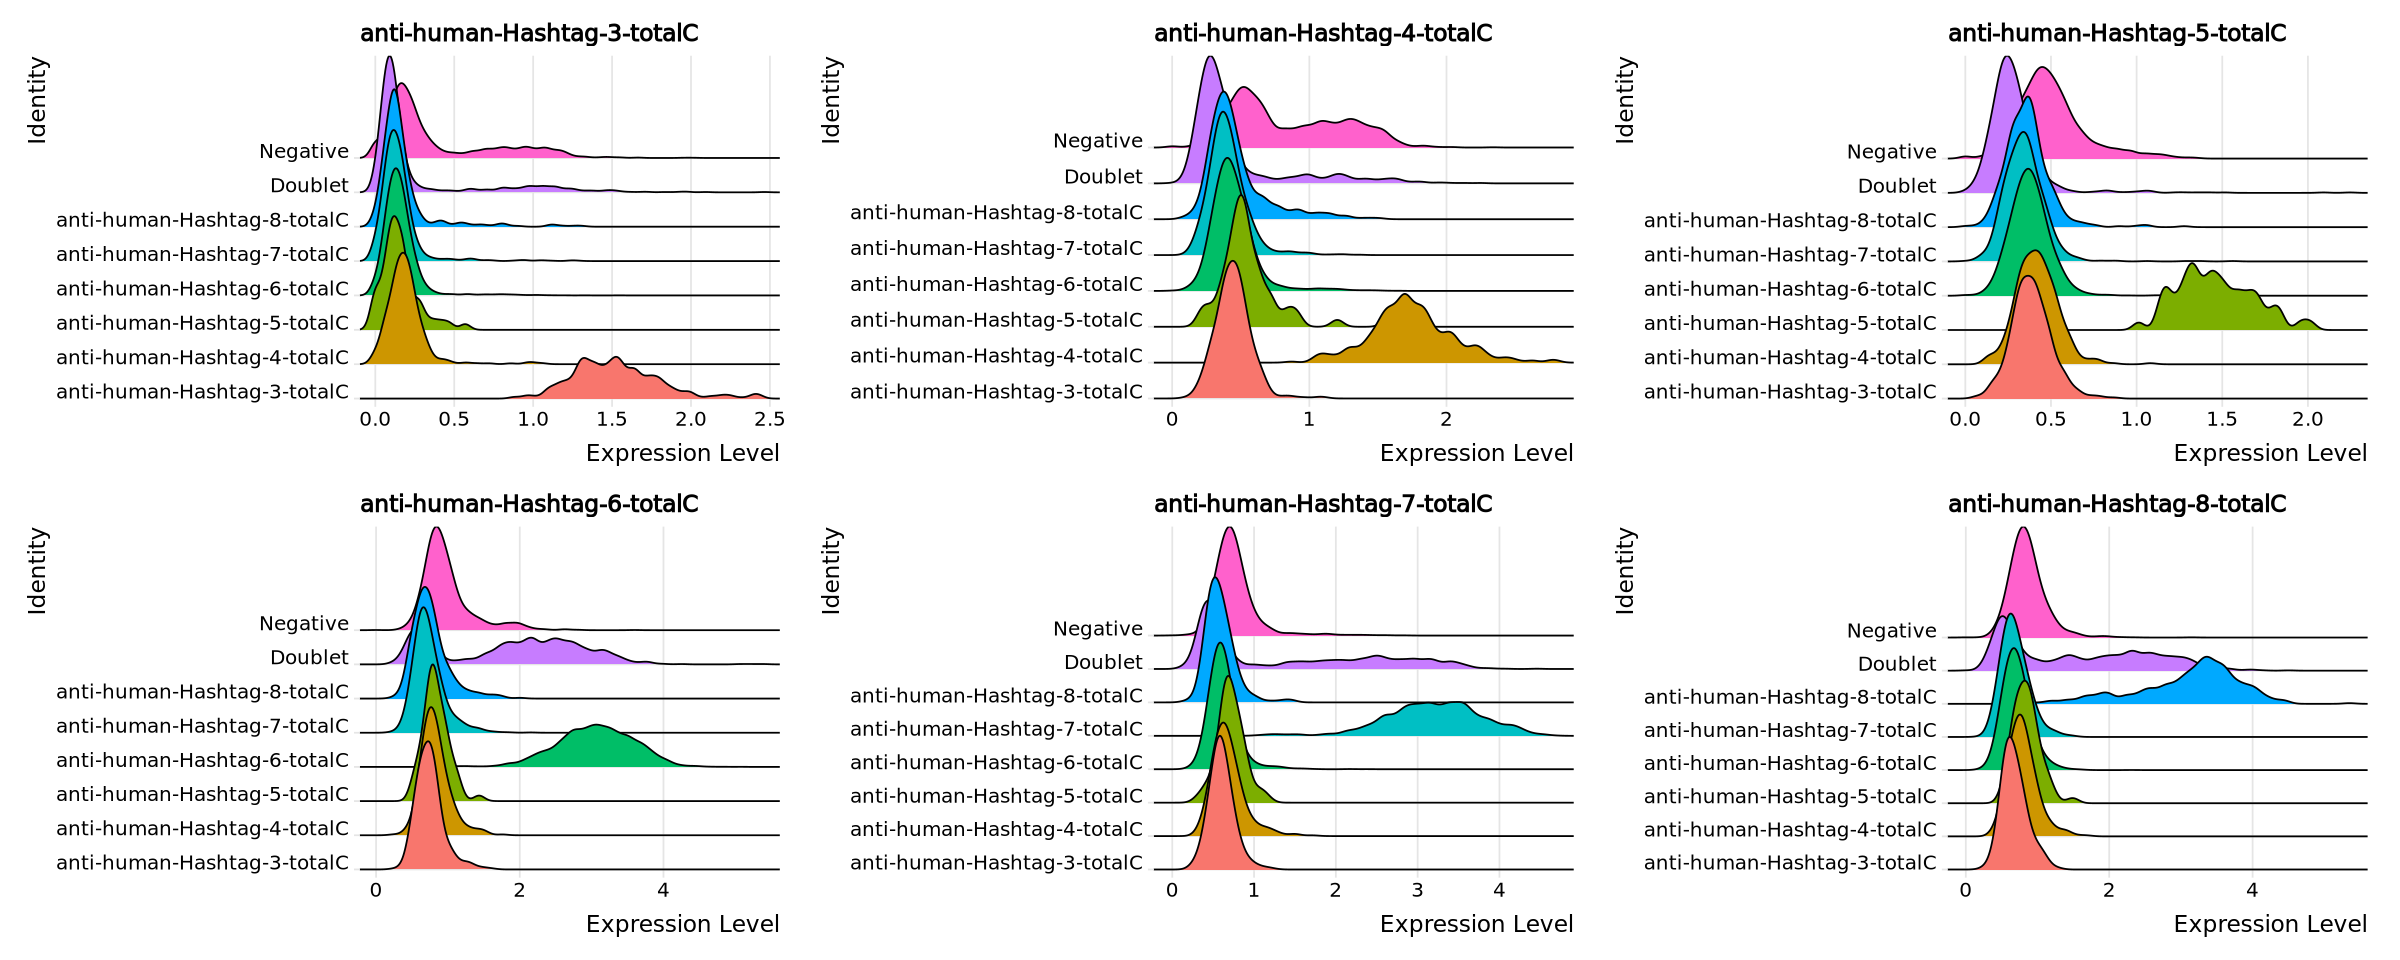

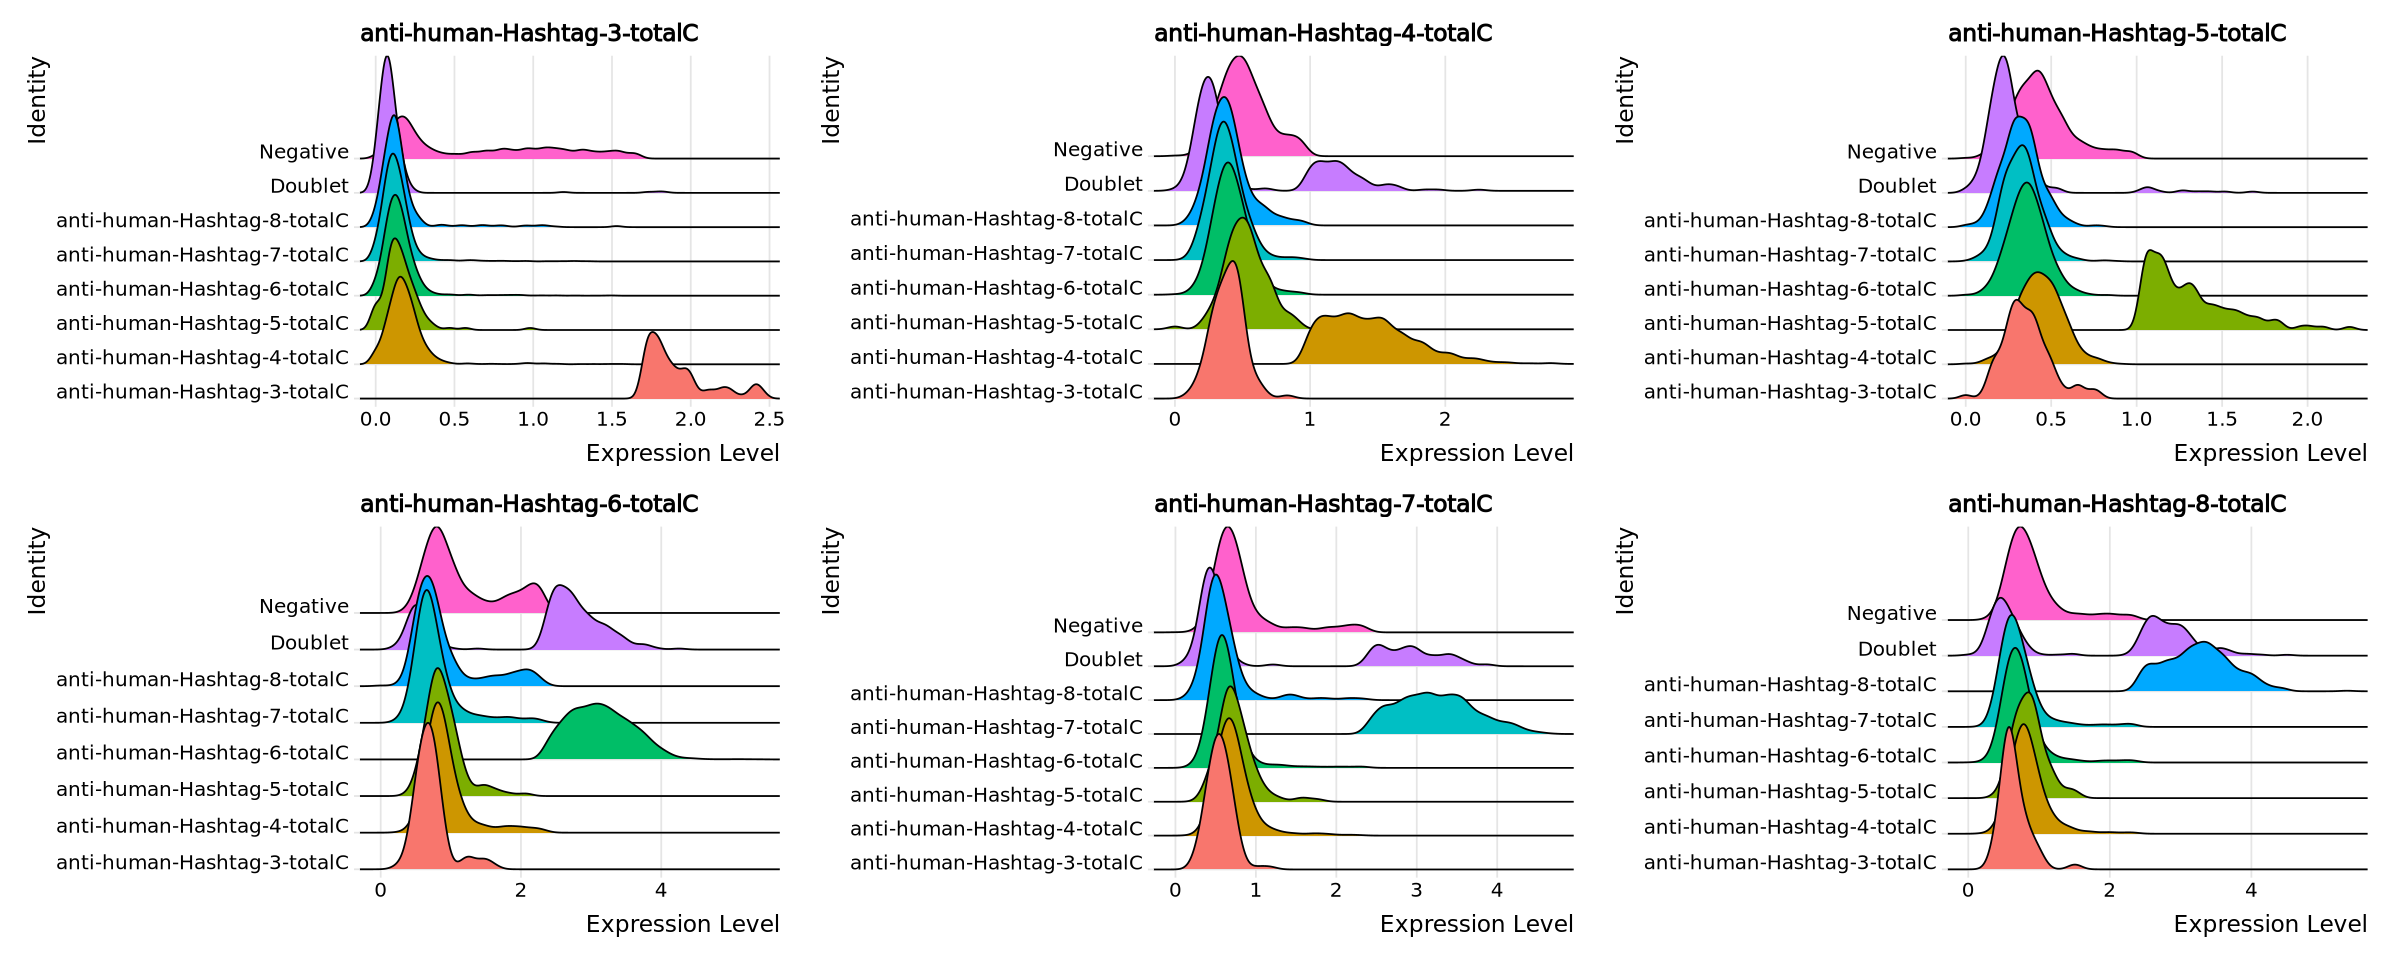

In [291]:
## Ridge plot of each hashtag in demultiplexed cells for filtered_matrix_1
options(repr.plot.width=20, repr.plot.height= 8)
RidgePlot(obj_list[[1]], assay = "HTO", group.by = "hash.ID", features = rownames(obj_list[[1]][["HTO"]]), ncol = 3)
RidgePlot(obj_list[[1]], assay = "HTO", group.by = "MULTI_ID", features = rownames(obj_list[[1]][["HTO"]]), ncol = 3)

Picking joint bandwidth of 0.0303

Picking joint bandwidth of 0.04

Picking joint bandwidth of 0.031

Picking joint bandwidth of 0.074

Picking joint bandwidth of 0.0729

Picking joint bandwidth of 0.0874

Picking joint bandwidth of 0.0271

Picking joint bandwidth of 0.0471

Picking joint bandwidth of 0.0306

Picking joint bandwidth of 0.0961

Picking joint bandwidth of 0.0849

Picking joint bandwidth of 0.089



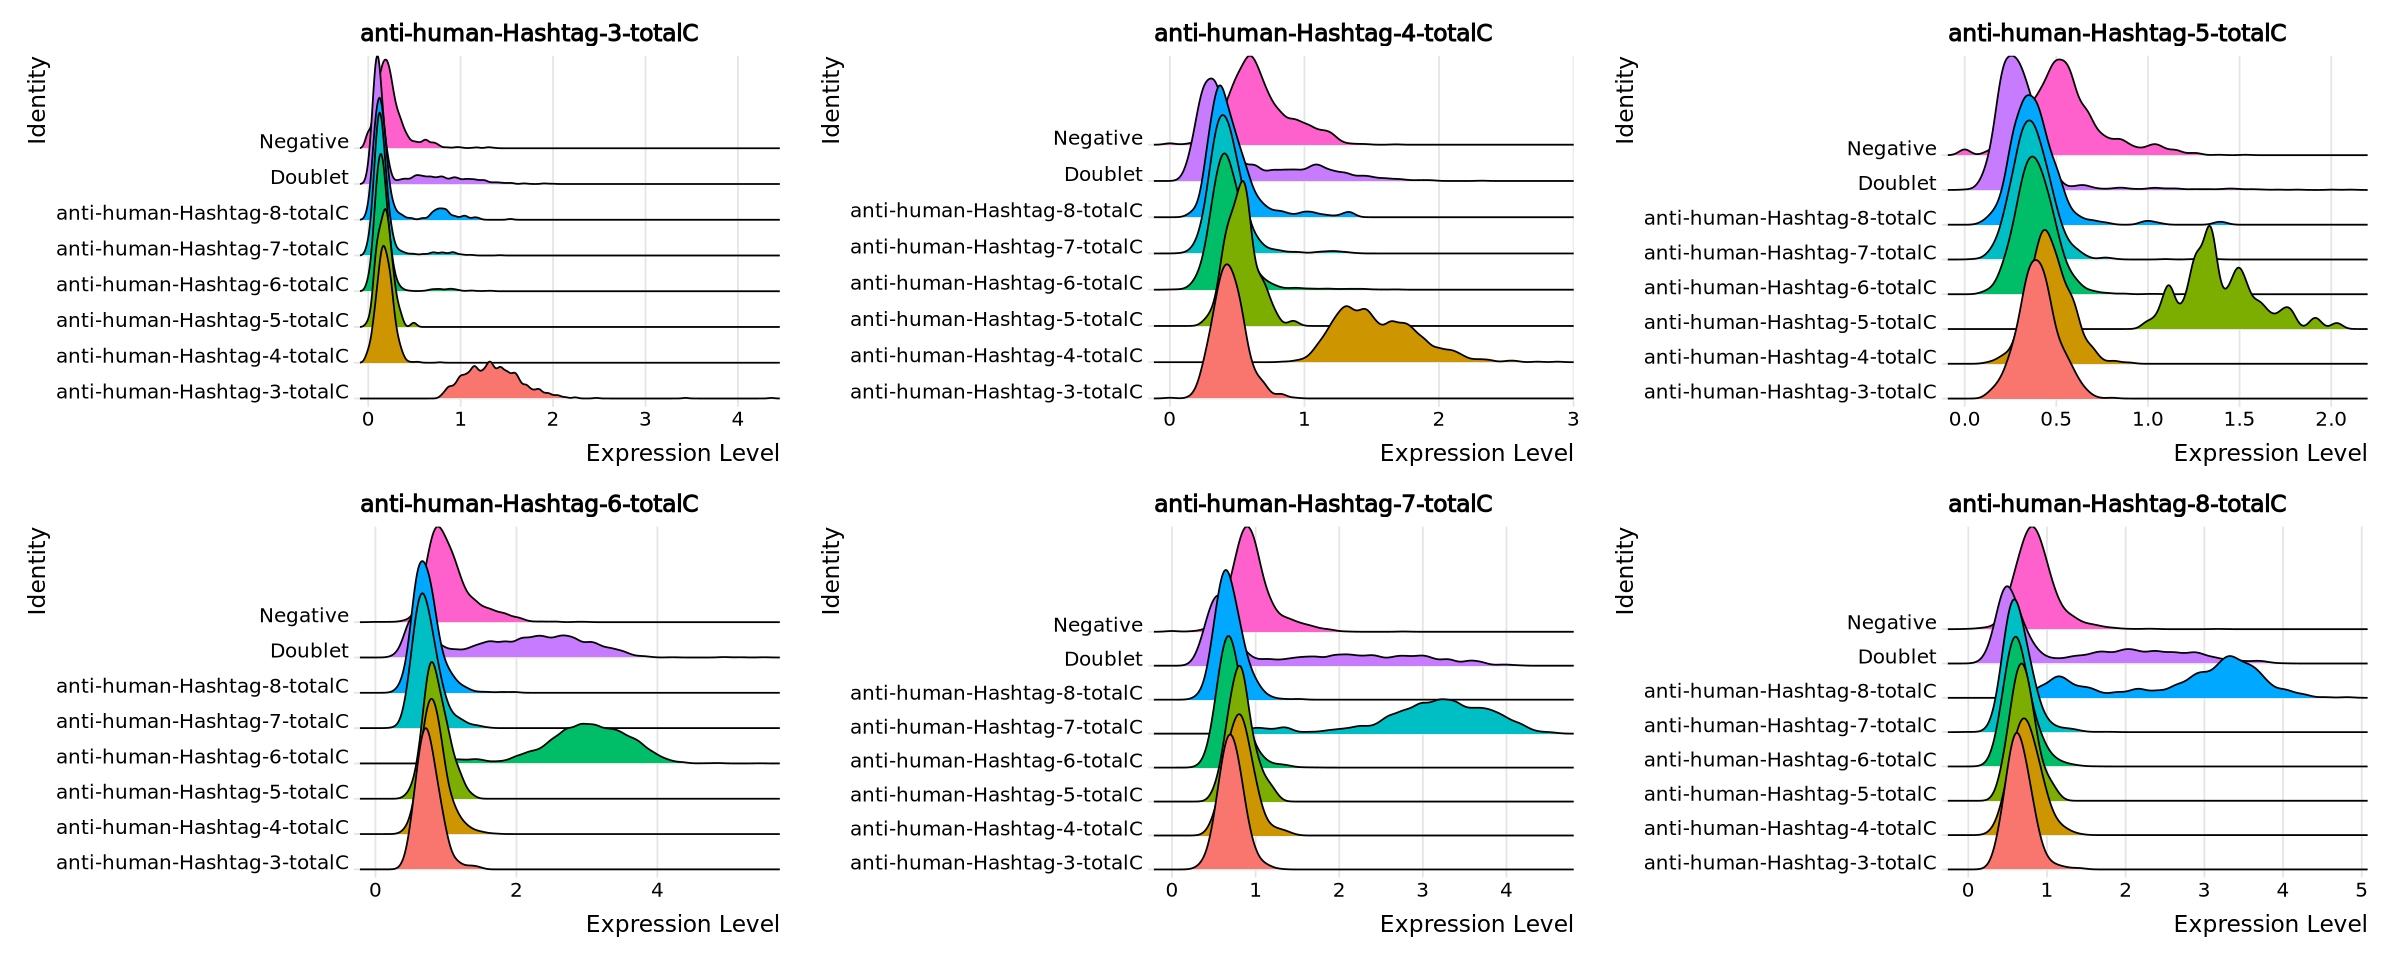

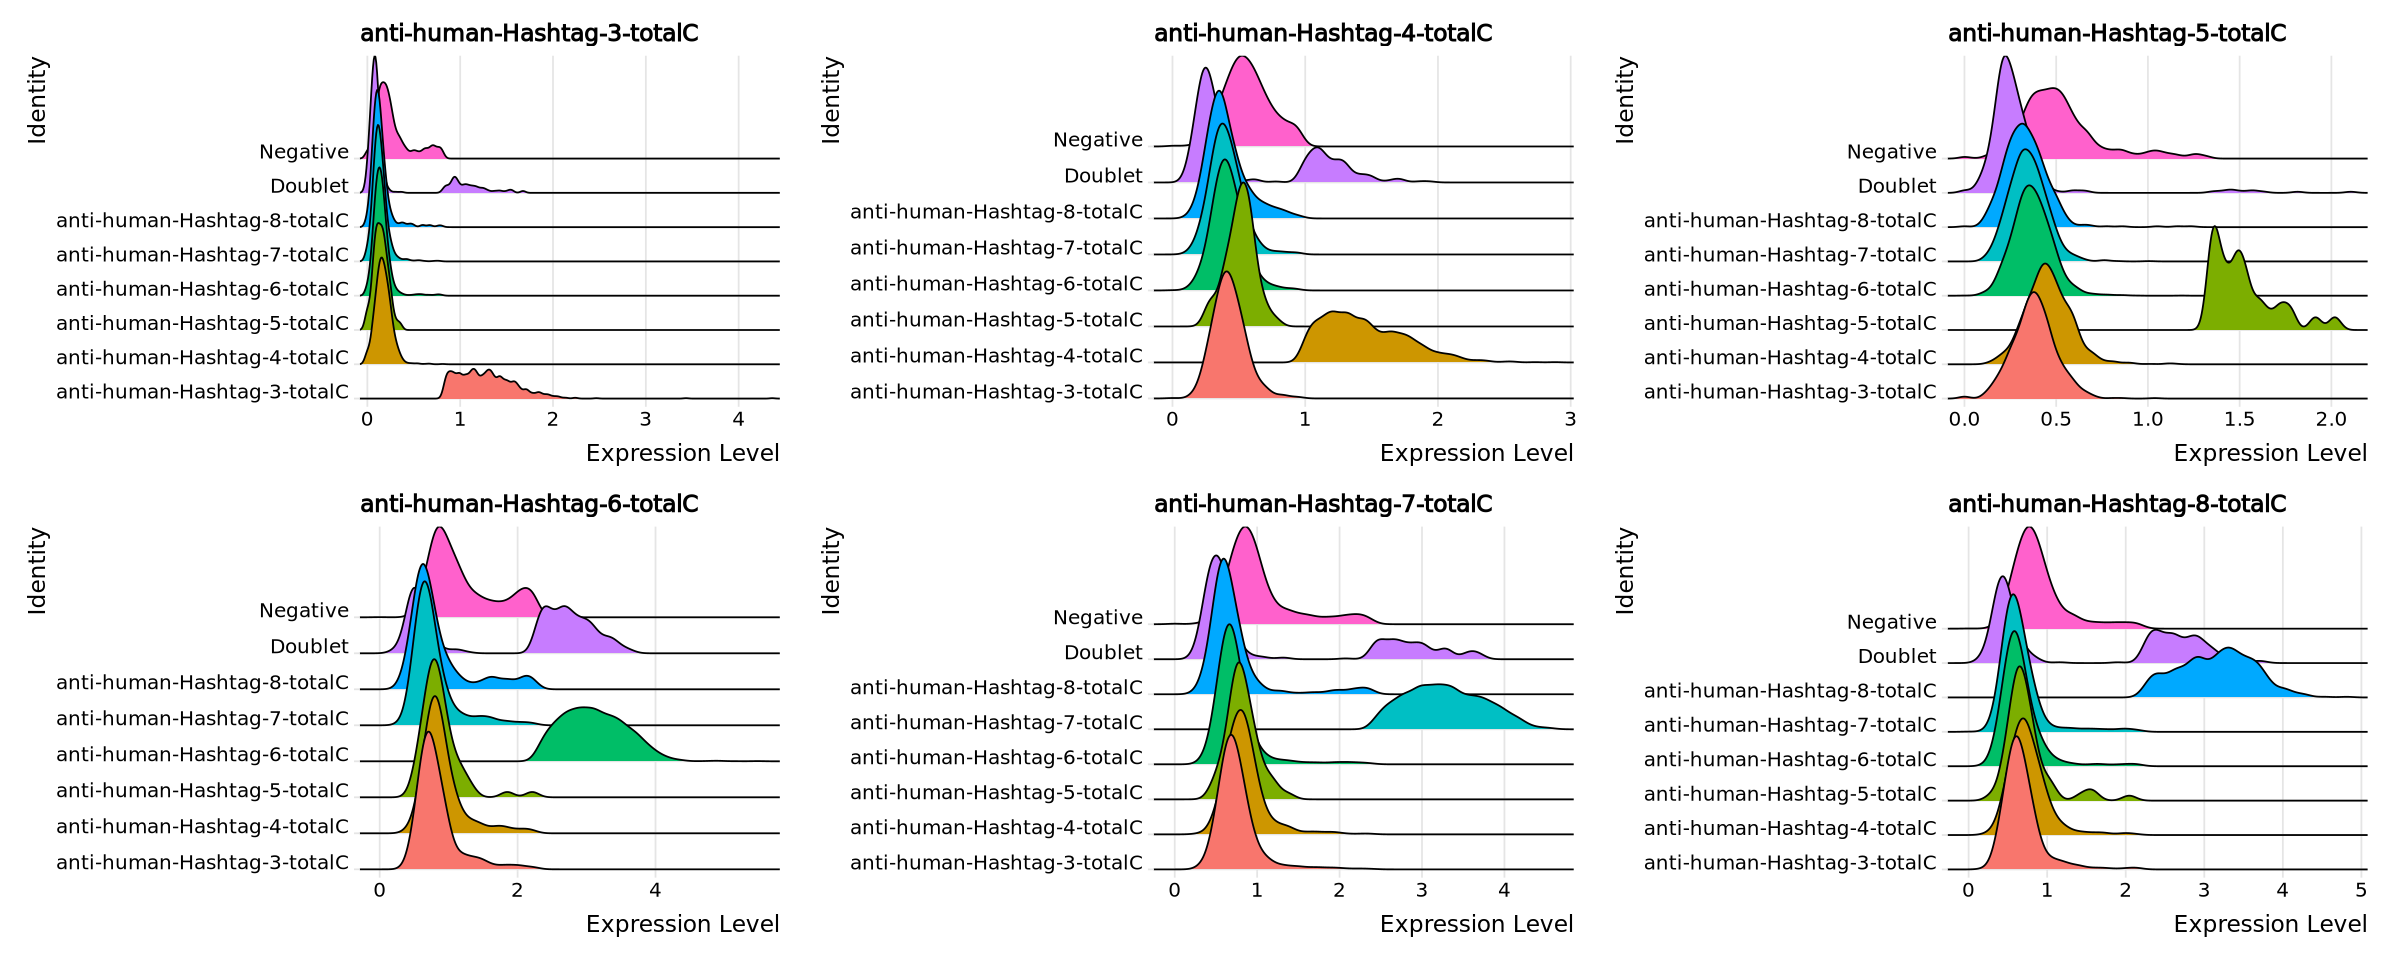

In [292]:
## Ridge plot of each hashtag in demultiplexed cells for filtered_matrix_2
options(repr.plot.width=20, repr.plot.height= 8)
RidgePlot(obj_list[[2]], assay = "HTO", group.by = "hash.ID", features = rownames(obj_list[[2]][["HTO"]]), ncol = 3)
RidgePlot(obj_list[[2]], assay = "HTO", group.by = "MULTI_ID", features = rownames(obj_list[[2]][["HTO"]]), ncol = 3)

In the following chapters, we will continue subsequent analysis using MULTIseqDemux output rather than HTODemux.

## Session Info {.unnumbered}

In [293]:
qsave(obj_list, "seurat/20240826_GSE155224_demux.qs")

In [294]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /nemo/lab/caladod/working/Matthew/.conda/envs/seurat5/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] qs_0.26.3                   viridis_0.6.4              
 [3] viridisLite_0.4.2           ggalluvial_0.12.5          
 [5] ggnewscale_0.4.9            ggrepel_0.9.4